In [4]:
import requests
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
import json

client = OpenAI()
s = requests.Session()

GROUP_THEM_URL = "http://127.0.0.1:8080/groupthem"

### WordGuess

In [9]:
todo

{'guesses': [], 'maximum_guesses': 6}

### GroupThem

In [23]:
from collections import defaultdict
from enum import Enum

models = ["gpt-4o", "gpt-4o-2024-08-06", "gpt-4o-mini", "gpt-3.5-turbo"]
schema = '{"reasoning": String, "connections": [String; 4]}'

class Status(Enum):
    WIN = 1
    LOSE = 2
    DROPPED = 3
    UKNWN = 4

result = {model: {"guesses": defaultdict(int)} for model in models}

def process(model: str):
    frequency_penalty = 0
    temperature = 1
    s = requests.Session()
    state = s.get(GROUP_THEM_URL).json()
    conversation = [
        {"role": "system", "content": "You are a helpful assistant. Create a json object with the connection groups & your reasoning. ### Schema\n" + schema },
        {"role": "user", "content": "Create the mentioned JSON object through trying to find a connection between exactly 4 of these items: " + ", ".join(state["available_words"]) + "."},
    ]
    
    for i in range(10):
        # Ask model to attempt connection
        response = client.chat.completions.create(
            model=model,
            messages=conversation,
            temperature=1.2,
            frequency_penalty=max(0, min(frequency_penalty, 2)),
        ).choices[0].message.content
        
        start = response.find("{")
        end = response.find("}", start)
        
        try:
            json_response = json.loads(response[start:end+1])
        except Exception as e:
            print(response)
            print(e)
            conversation.append({"role": "user", "content": "Invalid JSON object. Please try again following the schema: " + schema})
            
        print(f"\n>Guess: {json_response['connections']}\nReasoning: {json_response['reasoning']}")
        # Send connections
        payload = {"guess": json_response["connections"]}
        
        try:
            response = s.post(GROUP_THEM_URL, json=payload)
            if response.status_code != 200:
                
                result[model]["guesses"][Status.DROPPED] += 1
                frequency_penalty += 0.5
                temperature += 0.2
                if "guess already made" in response.text.lower():
                    conversation.append({"role": "user", "content": "WARNING: This guess was already made"})
                    print("Guess already made")
                    continue
                
                if "not a valid word" in response.text.lower():
                    conversation.append({"role": "user", "content": f"WARNING: {response.text}"})
                    print("Invalid word")
                    continue
                else:
                    print(f"\n### {response.text}")
                    break
            available_words = response.json()["available_words"]
        except Exception as e:
            print(e)
            break
        
        win = json_response["connections"][0] not in available_words
        print(f"Win: {win}\n")
        if len(available_words) == 0:
            print(f"### You won in {i+1} guesses!")
            result[model]
            break
        else:
            
            if win:
                frequency_penalty = 0
                temperature = 1
                result[model]["guesses"][Status.WIN] += 1
                conversation = [
                    {"role": "system", "content": "You are a helpful assistant. Create a json object with the connection groups & your reasoning. ### Schema\n" + schema },
                    {"role": "user", "content": "Create the mentioned JSON object through trying to find a connection between exactly 4 of these items: " + ", ".join(available_words) + "."},
                ]
            else:
                frequency_penalty += 0.5
                temperature += 0.2
                result[model]["guesses"][Status.LOSE] += 1
                conversation.append({"role": "user", "content": f"You were INCORRECT. Try again with different options."})

for model in models:
    print(f"# Model: {model}")
    process(model)
    print("\n---\n")

            

# Model: gpt-4o

>Guess: ['sun', 'star', 'moon', 'flower']
Reasoning: The connection between the chosen items involves their celestial and physical properties associated with light and time. The items are linked by their relation to natural phenomena, periods of the day, and their physical symbols in various cultures and contexts.
Win: False


>Guess: ['sun', 'flower', 'mushroom', 'banana']
Reasoning: I tried different variations and found a group of four that belong to the same context. These four items can be directly linked to elements of nature or agriculture, giving them a shared connection.
Win: False


>Guess: ['sun', 'moon', 'star', 'planet']
Reasoning: These items are celestial bodies mentioned in astronomical contexts.
Invalid word

>Guess: ['sun', 'star', 'moon', 'planet']
Reasoning: The items 'sun', 'star', 'moon', and 'planet' are all celestial objects found in outer space.
Invalid word

>Guess: ['flower', 'mushroom', 'sickle', 'banana']
Reasoning: The grouping is based on

{'gpt-4o': {'guesses': defaultdict(int,
              {<Status.LOSE: 2>: 4, <Status.DROPPED: 3>: 4})},
 'gpt-4o-2024-08-06': {'guesses': defaultdict(int,
              {<Status.LOSE: 2>: 4,
               <Status.WIN: 1>: 2,
               <Status.DROPPED: 3>: 1})},
 'gpt-4o-mini': {'guesses': defaultdict(int,
              {<Status.LOSE: 2>: 4, <Status.DROPPED: 3>: 3})},
 'gpt-3.5-turbo': {'guesses': defaultdict(int,
              {<Status.LOSE: 2>: 4,
               <Status.WIN: 1>: 1,
               <Status.DROPPED: 3>: 2})}}

### Convert to a graph

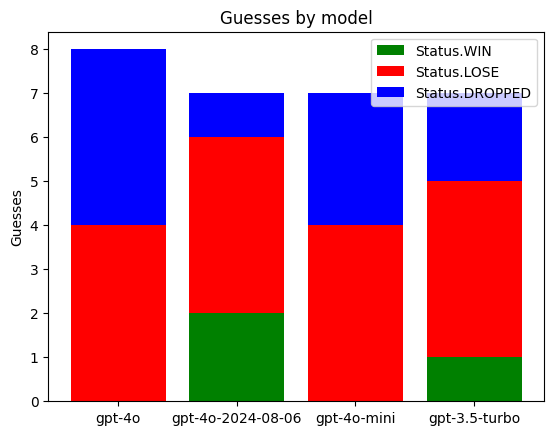

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for model in models:
    win = result[model]["guesses"][Status.WIN]
    lose = result[model]["guesses"][Status.LOSE]
    dropped = result[model]["guesses"][Status.DROPPED]
    
    ax.bar(model, win, color='g')
    ax.bar(model, lose, bottom=win, color='r')
    ax.bar(model, dropped, bottom=win+lose, color='b')

ax.set_ylabel('Guesses')
ax.set_title('Guesses by model')
ax.legend([Status.WIN, Status.LOSE, Status.DROPPED])
plt.show()